In [6]:
# load packages
import numpy as np 
import scipy.io
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
from itertools import chain
from scipy.optimize import curve_fit

### *Import File to Process*

In [7]:
# Main Directory of processed file from MatLab
MainDir = 'C:\\plimon\\SSRP_analysis_branch\\Contrast_Response_Functions\\' # set dir - on my computer
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Avilable Files to choose from: {len(d)}')
print(f'Files on hand: {d}')
##############################################
FileN_f1 = d[2] #  data    
print(FileN_f1) 
file_path1 = os.path.join(MainDir, FileN_f1) # join paths and prep 2 load
print( 'Group Imported:', file_path1.split('_')[-5], file_path1.split('_')[-4])
loadData = pkl.load(open(file_path1, 'rb'))
print('Keys Avialable:', loadData.keys())

Avilable Files to choose from: 4
Files on hand: ['SSRP_CntrlGroup_RCA1_CRF_20240627_150221.pkl', 'SSRP_CntrlGroup_RCA2_CRF_20240627_150307.pkl', 'SSRP_ExptGroup_RCA1_CRF_20240627_145808.pkl', 'SSRP_ExptGroup_RCA2_CRF_20240627_150025.pkl']
SSRP_ExptGroup_RCA1_CRF_20240627_145808.pkl
Group Imported: ExptGroup RCA1
Keys Avialable: dict_keys(['F1_Norm_CRF', 'F2_Norm_CRF', 'F1_Diffs', 'F2_Diffs', 'F1_CRF', 'F2_CRF', 'F1_Raw_Diffs', 'F2_Raw_Diffs', 'File_Location_Indicies', 'Subj_Num_Ids'])


### *Set Basic Plotting themes and colors*

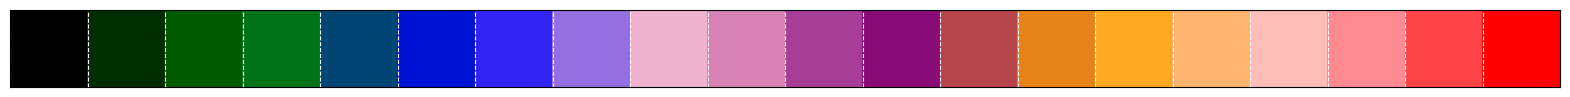

In [8]:
# Define the base colors for blending
base_colors = ['black','green', 'blue', 'pink' ,'purple', 'orange', 'pink','red']
# Number of colors needed in the spectrum
num_colors = 20
fill = sns.blend_palette(base_colors, n_colors=num_colors, as_cmap=False)
sns.palplot(fill)
plt.show()
# color_set = [11,1,8,4]
color_set = [0,12]
custom = {"axes.edgecolor": "black", "grid.linestyle": "dashed", "grid.color": "white"}
sns.set_style("darkgrid", rc = custom)

### *Set Fixed Parameters for  Hypoerbolic Ratio / Naka Rushton Fits*

In [9]:
Condition_Label = ['Potentiated, A+', 'Non-Pot, A+', 'Potentiated, A-', 'Non-Potentiated, A-']
crf_label = ['pre','post']
contrast_labs = ['1%','3%','5%','16%','40%','100%']
color_set = [3,6,12,13]

ContrastArr = np.array(np.arange(0.0,100,0.1)) # all contrast from 1% - 100% - ~1k data points
ContrastEnd = (ContrastArr.shape[0])
print('length of x array for contrasts: ', ContrastArr.shape)

x1 = np.linspace(0, 100, 6) # all 6 contrasts
x2 = np.linspace(0, 100, ContrastEnd) # all 100 contrasts
contrast_levels = [1,3,5,16,40,100]
param_names = ['C50','n','Rmax','b']

length of x array for contrasts:  (1000,)


### *Set Naka-Rushton Functions*

In [10]:
def naka_rushton(C, C50, n, Rmax, b):
    """
    This function models neural responses captured by Contrast Response Functions
     
    C50 (parameter 1) : Contrast level that yields half of max response (contrast %)
    n (parameter 2)   : Determines the curve arc for fitting (small integer)
    Rmax (Parameter 3): Max response elicited (mv)
    b (Parameter 4)   : Starting value (origin)
    """
    return ((Rmax * (( C ** n) / ( C50 ** n + C ** n))) + b)

def naka_rushton_saturation(C,C50,n,Rmax,b,s):
    """
    This function models neural responses captured by Contrast Response Functions with 
    1 extra parameter to fit supersaturating CRF towards higher contrasts
    NOTE: The extra parameters means that all 4 values from this fit are DIFFERENT interpretations of original NR funct.
     C50 (parameter 1) : Contrast level that yields half of max response (contrast %)
    n (parameter 2)   : Determines the curve arc for fitting (small integer)
    Rmax (Parameter 3): Max response elicited (mv)
    b (Parameter 4)   : Starting value (origin)
    s (Parameter 5)   : saturation index
    """
    return ((Rmax * (( C ** n) / ( C50 ** (s*n) + C ** (s*n)))) + b)

### *Functions to organize data for fitting: Saturation index, sorting*

In [11]:
def CombinePrePostResponses(DataIn, Cond2Import, HarmonicIndex):
    # combine data sets in terms of attention and hemifield, sorting ONLY
    Rows = int(len(DataIn))
    Cols = 2
    Data_PrePost_Mat = np.zeros((Rows,Cols,6)) # numsubs x contrasts            
    for combine in range(len(DataIn)):
        Data_PrePost_Mat[combine,:,:] = DataIn[combine][Cond2Import][HarmonicIndex,:,:]
    return Data_PrePost_Mat

In [12]:
def Store_SaturationIndex_Information(dataIn):
    """This function calculates the saturation index for pre and post contrast reponse functions 
        per particpant per condition if it is looped properly.
        Returns: Saturation index calulated for both pre and post CRF's + Location where the maximum reponse was found"""

    PrePost_SaturationValues = np.zeros((int(dataIn.shape[0]),2)) #[subjx xsaturation index values]  # saturation index evaluation
    PrePost_SaturationValues_LocInstance = np.zeros((int(dataIn.shape[0]),2)) #[subj x saturation index values] # where saturation occured

    for CRF_SaturationEval in range(dataIn.shape[0]): # iterate through all subjects
        for prepost in range(2): # iterate through pre post crfs
            
            crf_data = dataIn[CRF_SaturationEval,prepost] # import 1 crf per iter

            MaxResponseLoc = np.argmax(crf_data) # find where maximum response is
            MaxResponseVal = crf_data[np.argmax(crf_data)] # find what ax response was given the locaiton

            Response_at_100 = crf_data[5] # response at 100% contrast

            pseudo_C50 = crf_data[3] # reponse at 60% contrast, not 40% or 50% (we dont have 50% :())
            #SI_response_change = (Response_at_100 - pseudo_C50)/ MaxResponseVal # Saturation Index Computation (Ledgeway et al. 2005) 
            PrePost_SaturationValues[CRF_SaturationEval,prepost] = (Response_at_100 - pseudo_C50)/ MaxResponseVal #store satruation index 
            PrePost_SaturationValues_LocInstance[CRF_SaturationEval,prepost] = MaxResponseLoc # store contrast with saturation index    

    return PrePost_SaturationValues, PrePost_SaturationValues_LocInstance
#############################################################################################################################
# make empty bool to index saturating group and non saturarating crf group for analysis
def GetSaturationIndex_Bool(SaturationValuesIn, CRFs_In): 
    """Since there are many contrast response functions to analyze, here we make a bool for what CRF's displayed
        suspersturation.
        Returns: A binary array to index saturation and +increasing CRFs for pre and post CRFs
        1 == Saturation was present, 0 == Consistent + Increasing CRF
        
        Note: Make sure to remove nan subjs bc they are automitically assigned to SI = 0"""
    Saturation_Bool_PrePost = np.zeros((SaturationValuesIn.shape[0],2)) # bool index, 1 == saturation, 0 = no saturation identified
    #print(Saturation_Bool_PrePost.shape) # [subs (38) , saturation index bool to fill]

    for prepost in range(2):
        for xSubiters in range(CRFs_In.shape[0]):
            SatIndex = SaturationValuesIn[xSubiters,prepost]
            if SatIndex < 0: # if a value is less than 0, append to saturation group 
                #print(f'saturation occured in subject {subjectCRF}')
                Saturation_Bool_PrePost[xSubiters,prepost] = 1
            else: # or else keep as a linear increase crf, as expected
                Saturation_Bool_PrePost[xSubiters,prepost] = 0
    Saturation_Bool_Total = np.sum(Saturation_Bool_PrePost,axis = 1) # returns 0,1,2  | 0 = No saturation, 2 = Saturation on all CRF's

    return Saturation_Bool_PrePost,Saturation_Bool_Total
###########################################################################################################################
def SegmentConditionsPerSaturationgroups(data2divy,bool2Use):
    Saturation_Group = data2divy[bool2Use > 0,:,:]
    Linear_Group = data2divy[bool2Use == 0,:,:]

    dataset = [Saturation_Group,Linear_Group]

    prepost_mat_out = []
    prepost_std_mat_out = []

    for setIn in range(2):
        CRF_Response = np.zeros((2,6))
        get_errorbars = np.zeros((2,6))
        for prepost in range(2):
            CRF_Response[prepost,:] = np.nanmean(dataset[setIn][:,prepost,:],axis = (0))
            get_errorbars[prepost,:] = np.nanstd(dataset[setIn][:,prepost,:],axis = 0) / np.sqrt(np.count_nonzero(~np.isnan(dataset[setIn][:,prepost,0])))

        prepost_mat_out.append(CRF_Response)
        prepost_std_mat_out.append(get_errorbars)

    return prepost_mat_out,prepost_std_mat_out,dataset#Saturation_Group, Linear_Group

### *Import Processed, Normalized Contrast Response Function Data and sort*

In [13]:
# indexing certain harmonics ,,,, note sure if this does anything here tho 
Harmonic_Range_To_Include = np.arange(0,2)
NR_Harmonic_Range = Harmonic_Range_To_Include
FirstIndex = int(NR_Harmonic_Range[0])
LastIndex = int(NR_Harmonic_Range [1] + 1)

In [14]:
# subject names and arrays to index attnL and attnR expts
File_Pos = loadData['File_Location_Indicies']
Subj_Ids = loadData['Subj_Num_Ids']
## clean pre post CRF's
F1_Responses = loadData['F1_Norm_CRF']
F2_Responses = loadData['F2_Norm_CRF']

In [15]:
crf_nans = np.zeros((4,2,6))
diff_nans = np.zeros((4,6))
crf_nans[:] = np.nan
diff_nans[:] = np.nan

In [16]:
# sort! 
CRF_IndividualResponses_Sorted = []

for iter in range(len(Subj_Ids)):

    Subj_Title = Subj_Ids[iter] # subject 
    Indiv_File_Locations = File_Pos[iter,:] # import file locations for data
    AttendL_Condition = Indiv_File_Locations[0] # attnL file
    AttendR_Condition = Indiv_File_Locations[1] # attnR file

    # If both locations contain NaNs, replace all data
    if np.isnan(AttendL_Condition) and np.isnan(AttendR_Condition):
        CRF_Set = [crf_nans, crf_nans, crf_nans, crf_nans]
        print('Both AttnL and AttnR files are missing, now replacing all data ...')
        print(Indiv_File_Locations)
    # If the first position contains a NaN, replace with NaN data for F1 and F2
    elif np.isnan(AttendL_Condition):
        print('Attn L file is missing, now replacing ...')
        print(Indiv_File_Locations)
        CRF_Set = [crf_nans, crf_nans, F1_Responses[int(AttendR_Condition)], F2_Responses[int(AttendR_Condition)]]
    # If the second position contains a NaN, replace with NaN data for F1 and F2
    elif np.isnan(AttendR_Condition):
        print('Attn R file is missing, now replacing ...')
        print(Indiv_File_Locations)
        CRF_Set = [F1_Responses[int(AttendL_Condition)], F2_Responses[int(AttendL_Condition)], crf_nans, crf_nans]
    else:
        print('Both AttnL and AttnR files are present.')
        print(Indiv_File_Locations)
        CRF_Set = [F1_Responses[int(AttendL_Condition)], F2_Responses[int(AttendL_Condition)], F1_Responses[int(AttendR_Condition)], F2_Responses[int(AttendR_Condition)]]
        
    CRF_IndividualResponses_Sorted.append(CRF_Set)

Both AttnL and AttnR files are present.
[0. 1.]
Both AttnL and AttnR files are present.
[2. 3.]
Both AttnL and AttnR files are present.
[4. 5.]
Both AttnL and AttnR files are present.
[6. 7.]
Both AttnL and AttnR files are present.
[8. 9.]
Both AttnL and AttnR files are present.
[10. 11.]
Both AttnL and AttnR files are present.
[12. 13.]
Both AttnL and AttnR files are present.
[14. 15.]
Attn R file is missing, now replacing ...
[16. nan]
Both AttnL and AttnR files are present.
[17. 18.]
Both AttnL and AttnR files are missing, now replacing all data ...
[nan nan]
Both AttnL and AttnR files are present.
[21. 22.]
Both AttnL and AttnR files are present.
[23. 24.]
Both AttnL and AttnR files are present.
[25. 26.]
Both AttnL and AttnR files are present.
[27. 28.]
Both AttnL and AttnR files are present.
[29. 30.]
Both AttnL and AttnR files are present.
[31. 32.]
Both AttnL and AttnR files are present.
[33. 34.]
Both AttnL and AttnR files are present.
[35. 36.]
Both AttnL and AttnR files are 

#### *Should have 4 indices, each for : Pot Attn Cong, NonPot Attn Congr, Pot Attn Incong, NonPot Attn Incong*

In [17]:
print(len(CRF_IndividualResponses_Sorted)) # [subject , 4 condtions, harmonic, prepost , contrast]
print(len(CRF_IndividualResponses_Sorted[0])) # 1 subjects perfomrance for boht sessions for each hemisphere
print((CRF_IndividualResponses_Sorted[0][0].shape)) # Harmonic CRF, PrePost Values, Response per sweep

38
4
(4, 2, 6)


### *Combine CRF's into a single array, for a single harmonic at a time*

### *7/11/24 to do: make a for loop to get high harmonic data for fits*

In [18]:
PrePostConditionData = {}
for CondX in range(4):
    PrePostConditionData[CondX] = CombinePrePostResponses(DataIn = CRF_IndividualResponses_Sorted, Cond2Import = CondX, HarmonicIndex = 0)
    print(PrePostConditionData[CondX].shape)

(38, 2, 6)
(38, 2, 6)
(38, 2, 6)
(38, 2, 6)


#### *Based on above, plot saturatation trend across Hemisphere for Attn-Congruent and Incongruent Condition*

In [19]:
Vals = [] 
SaturatingSweep = []

for CondX in range(4):
    CondX_Vals, CondX_SaturatingSweep = Store_SaturationIndex_Information(dataIn = PrePostConditionData[CondX])
    Vals.append(CondX_Vals)
    SaturatingSweep.append(CondX_SaturatingSweep)

In [20]:
# fig,axs = plt.subplots(1,4,figsize = ((28,5)),sharey = True)

# for coV in range(4):
#     SI_Values_PrePost = np.array(Vals[coV])

#     SI_label = ['pre','post']
#     for i in range(SI_Values_PrePost.shape[1]):
#         axs[coV].scatter(np.arange(0,SI_Values_PrePost.shape[0],1),SI_Values_PrePost[:,i],color = fill[9+i], label = SI_label[i])
#         #plt.plot(SI_Values_PrePost[:,i],color = fill[9+i])
#         axs[coV].hlines(0,xmin = 0,xmax = int(SI_Values_PrePost.shape[0]), color = fill[0])
#         axs[coV].legend(loc = 'lower right')
#         axs[coV].set_title(f'Saturation Index Cond: {Condition_Label[coV]}')

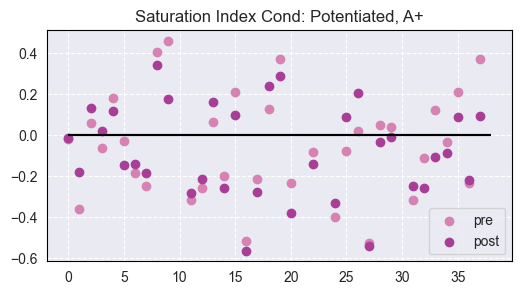

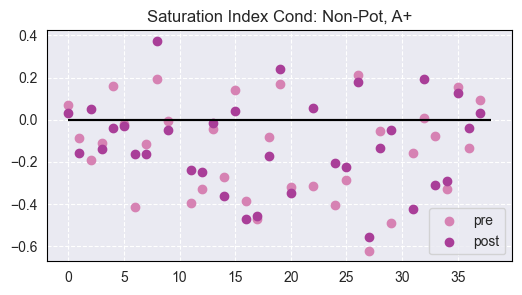

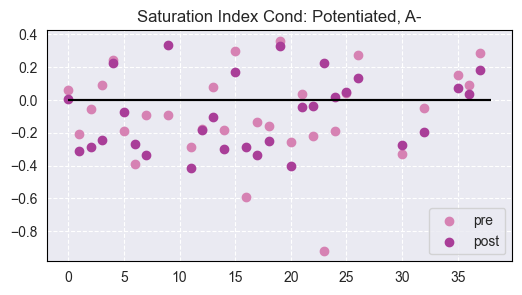

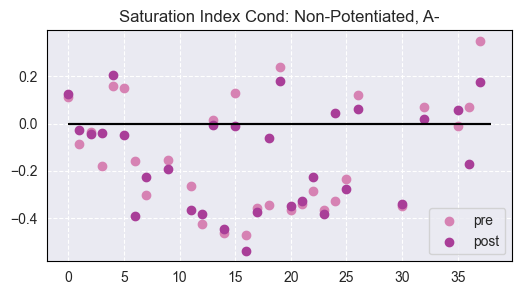

In [81]:
for coV in range(4):
    SI_Values_PrePost = np.array(Vals[coV])

    fig,axs = plt.subplots(figsize = ((6,3)))
    for i in range(SI_Values_PrePost.shape[1]):
        axs.scatter(np.arange(0,SI_Values_PrePost.shape[0],1),SI_Values_PrePost[:,i],color = fill[9+i], label = crf_label[i])
        #plt.plot(SI_Values_PrePost[:,i],color = fill[9+i])
        axs.hlines(0,xmin = 0,xmax = int(SI_Values_PrePost.shape[0]), color = fill[0])
        axs.legend(loc = 'lower right')
        axs.set_title(f'Saturation Index Cond: {Condition_Label[coV]}')

In [22]:
Saturation_Bool_group = []
Saturation_Counts = [] # wull use this index to identiy saturating CRF groups

for CondX in range(4): 
    sbg, sc = GetSaturationIndex_Bool(SaturationValuesIn = Vals[CondX], CRFs_In= PrePostConditionData[CondX])
    Saturation_Bool_group.append(sbg)
    Saturation_Counts.append(sc)

### *Will use the below array to index between saturating and non saturing responses*

In [23]:
Saturation_Subjs = np.array(Saturation_Counts[0])
print(np.unique((Saturation_Counts[0]),return_counts = True))
print(Saturation_Subjs)

(array([0., 1., 2.]), array([15,  5, 18], dtype=int64))
[2. 2. 0. 1. 0. 2. 2. 2. 0. 0. 0. 2. 2. 0. 2. 0. 2. 2. 0. 0. 2. 0. 2. 0.
 2. 1. 0. 2. 1. 1. 0. 2. 2. 1. 2. 0. 2. 0.]


##### *Run Original NakaRushton with Non-Saturating, Normalized Contrast Response Functions*

### *NakaRushton Fit Boundaries*

In [24]:
### Model Estimates...based on nothing soild - subject to change 
c50_b = [0,50] # contrast level that yields 50% of max response
n_b = [0,4] # determin curve arc for fitting 
Rmax_b = [0,1] # max response, post-normalization maxrespone = ~ 1.25 / 1.3
b_b = [0,0.5] # starting value, should be around 0-0.9 ish
boundaries=([c50_b[0],n_b[0],Rmax_b[0],b_b[0]], [c50_b[1],n_b[1],Rmax_b[1],b_b[1]]) # Boundary Params for C50, N, Rmax and B
startingGuess = [40,0.1,1,0] # Initial guess for 2f params

In [77]:
# get non-saturating CRFs to fit and derive values from 
nr_Group = []
for CondX in range(4):
    #grouped_data = PrePostConditionData[CondX][Saturation_Subjs == 0,:,:] # No Saturation group, SI == 0
    grouped_data = PrePostConditionData[CondX][Saturation_Subjs > 0,:,:] # Supersaturaton group, SI< 0 
    nr_Group.append(grouped_data)

In [78]:
print(nr_Group[0][0,0,:])
print(nr_Group[1][0,0,:])

[0.13062946 0.35761936 0.59469191 0.85157679 1.         0.83510569]
[0.08871668 0.38614387 0.65625774 0.91488146 1.         0.98432473]


Text(0.5, 0.98, 'CRF Pre Post, SI == 0')

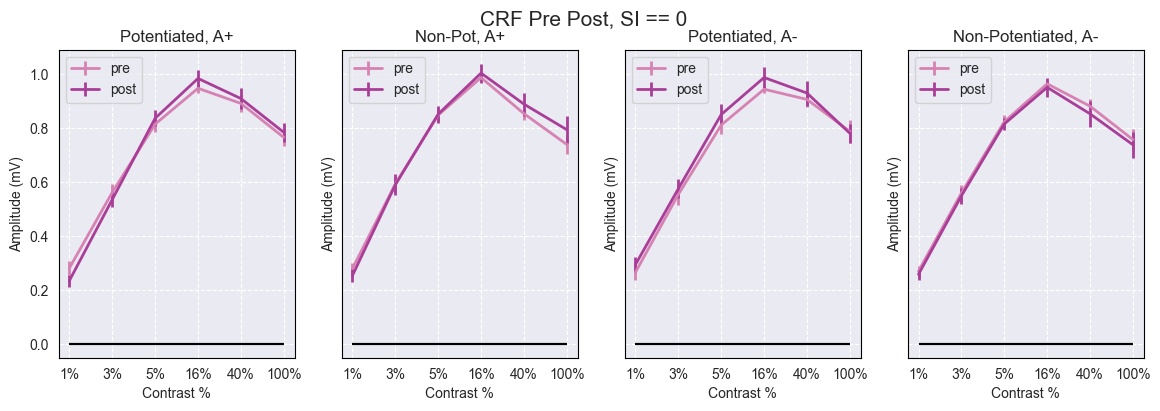

In [79]:
fig,axs = plt.subplots(1,4,figsize = ((14,4)), sharey = True)

for x in range(4):
    condition = np.array(nr_Group[x])
    NumObvs = np.sqrt(np.count_nonzero(~np.isnan(condition[:,0,0]))) # get number of subjs
    for prepost in range(2):
        prepost_avgs = np.nanmean(condition[:,prepost,:],axis = 0)
        prepost_stds = np.nanstd(condition[:,prepost,:],axis = 0) / NumObvs
        #axs[x].plot(prepost_avgs, label =crf_label[prepost], color = fill[9+prepost])
        axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,label =crf_label[prepost], color = fill[9+prepost], linewidth = 2)
        axs[x].set_title(f'{Condition_Label[x]}')
        axs[x].set_ylabel(f'Amplitude (mV)')
        axs[x].set_xlabel(f'Contrast %')
        axs[x].set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
        axs[x].hlines(0,xmin = 0,xmax = 5, color = 'black')
        axs[x].legend()
plt.suptitle(f'CRF Pre Post, SI == 0', fontsize = 15)

### What ryan wants: for every particpant get SI and then use a function like mas to identify max response, and it its not at 100% take repsone at peack and - response 100% 
# do particpants 

#### *to do: 7/12/24| plot pre post differences again*

In [28]:
# dummy data for pre-exisiting nan data (missing files)
emptyMat = np.zeros((1,4))
emptyMat[:] = np.nan

In [29]:
AllCondition_FitParams = []

for nr_group_in in range(4):
    nr_group_data = np.array(nr_Group[nr_group_in])
    Fit_Params = np.zeros((nr_group_data.shape[0],2,4)) # [numsubs x prepost x fit outputs for hyperbolic ratio values]

    for subj in range(nr_group_data.shape[0]):
        for prepost in range(2):
            functs_In = nr_group_data[subj,prepost,:]
            if np.isnan(functs_In).all():
                #print(f'skipping this computation..., data not avilable: {subj,prepost}')
                Fit_Params[subj,prepost,:] = emptyMat
            else: 
                Fit_Params[subj,prepost,:], _ = curve_fit(naka_rushton,contrast_levels,functs_In,p0 = [20,0.05,1,0], bounds = boundaries,nan_policy='omit', method='trf')
    AllCondition_FitParams.append(Fit_Params)

In [30]:
AllCondition_SmoothFits = []

for nr_group_in in range(4):
    nr_group_fitVals = np.array(AllCondition_FitParams[nr_group_in]) # params form curve fit
    SmoothFitsOut = np.zeros((nr_Group[nr_group_in].shape[0],2,int(len(ContrastArr)))) # empty array to make smooth fits

    for subjFitVals in range(nr_group_fitVals.shape[0]):
        for prepost in range(2):
            SmoothFits = np.array(nr_group_fitVals[subjFitVals,prepost,:]) # 4 values 
            SmoothFitsOut[subjFitVals,prepost,:] = naka_rushton(ContrastArr,SmoothFits[0],SmoothFits[1],SmoothFits[2],SmoothFits[3])
    AllCondition_SmoothFits.append(SmoothFitsOut)

In [31]:
crf__loc_vals = np.array(contrast_levels) - 1

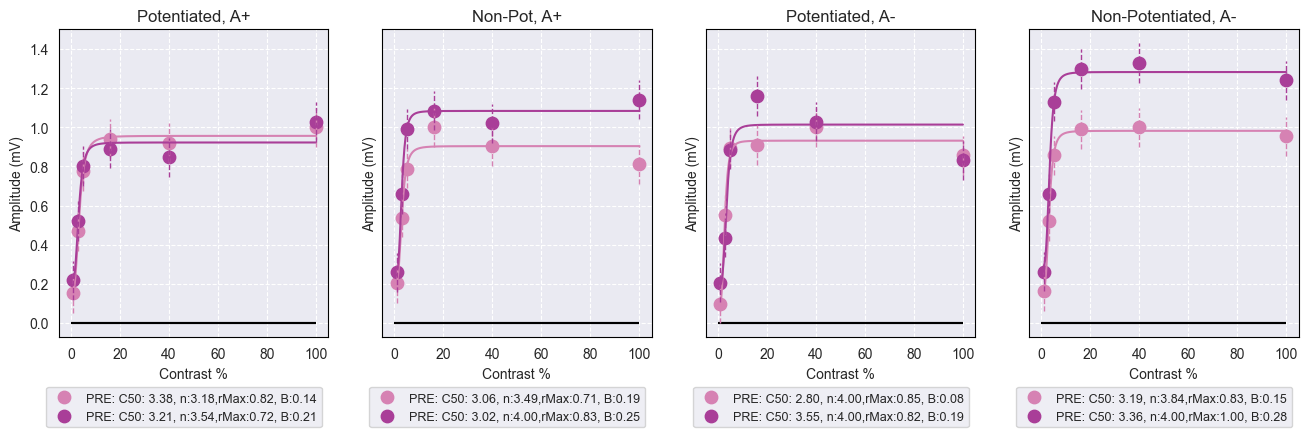

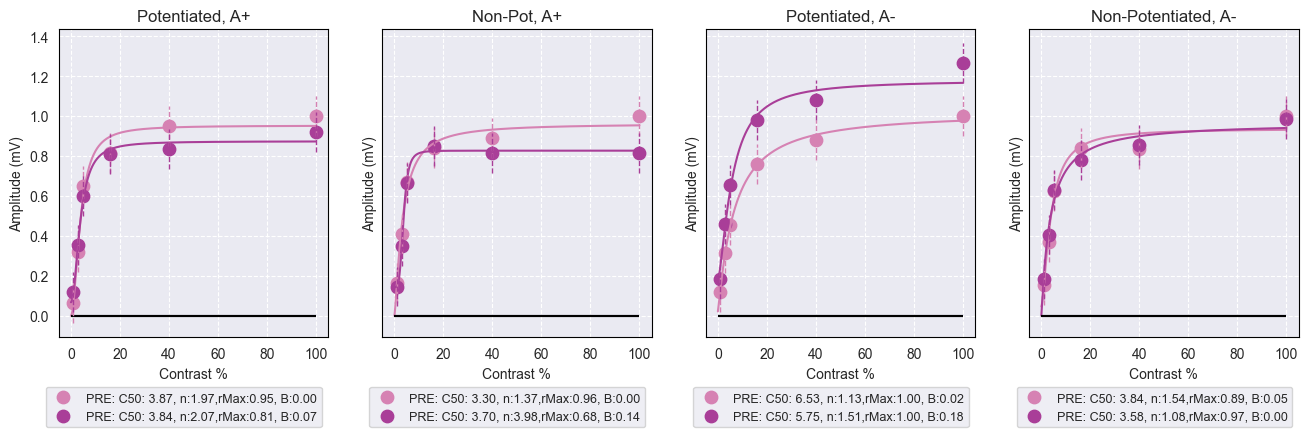

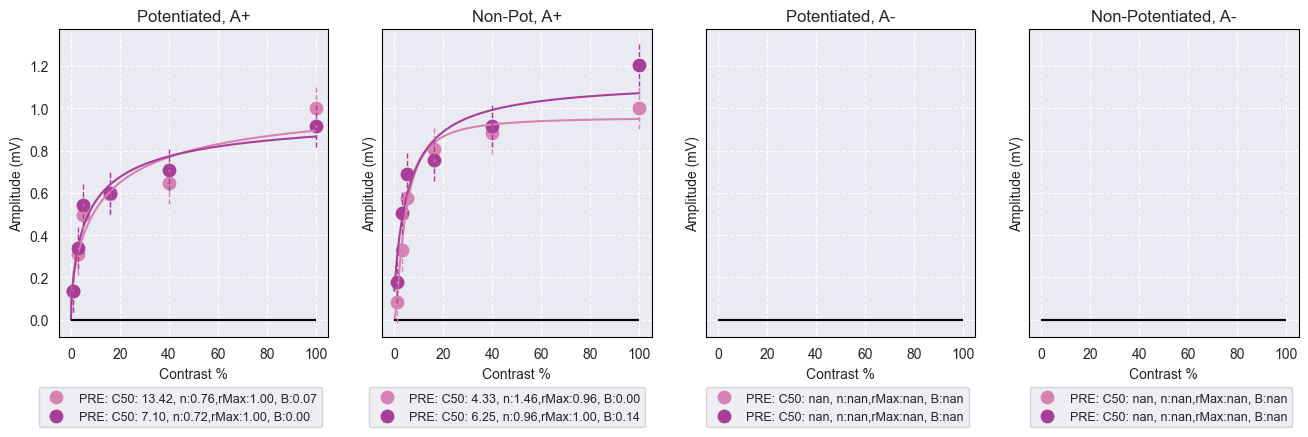

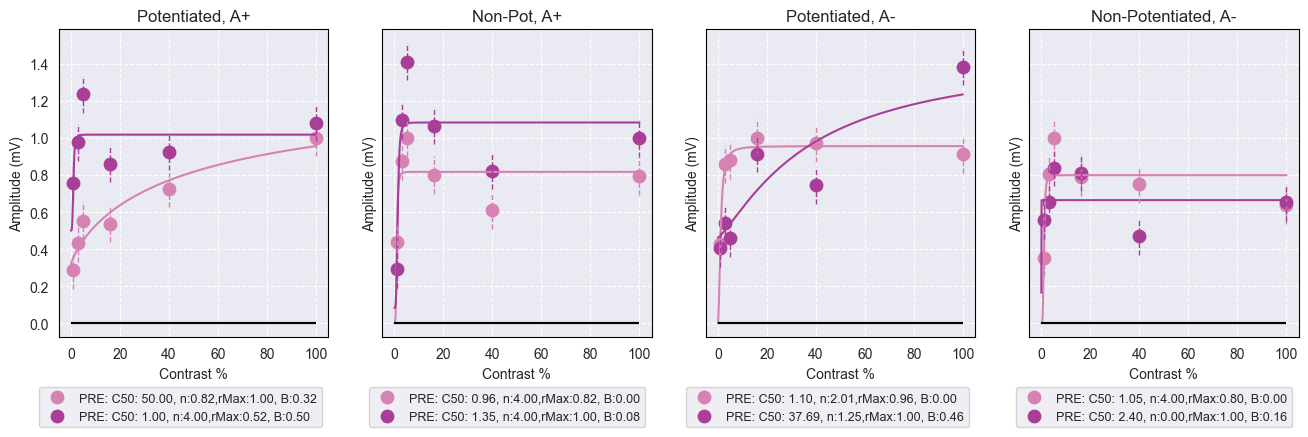

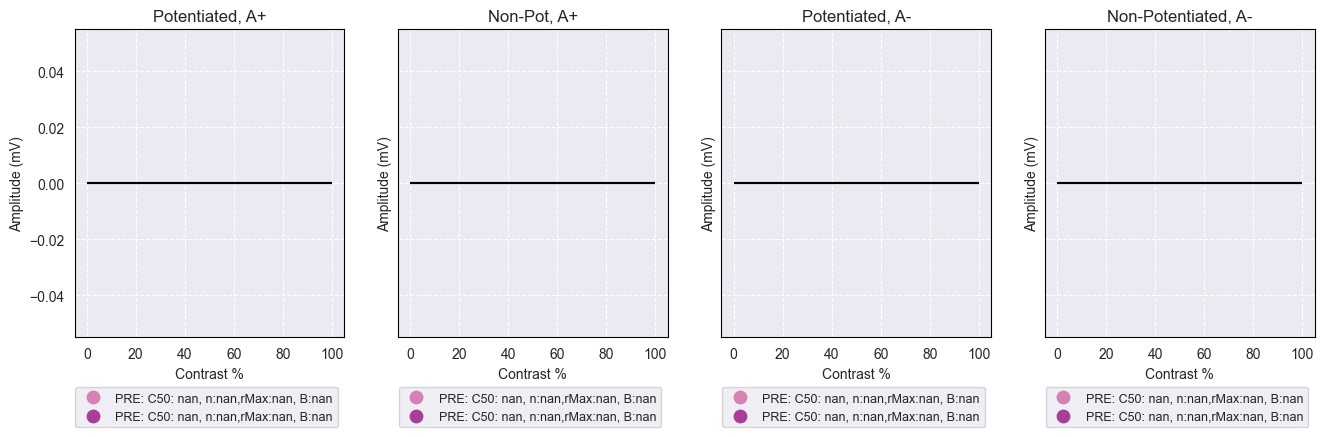

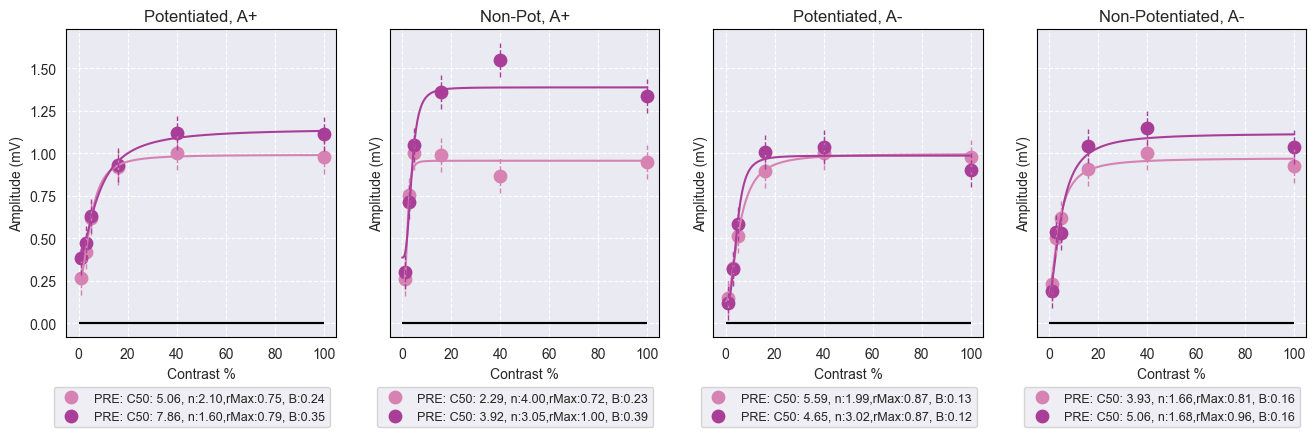

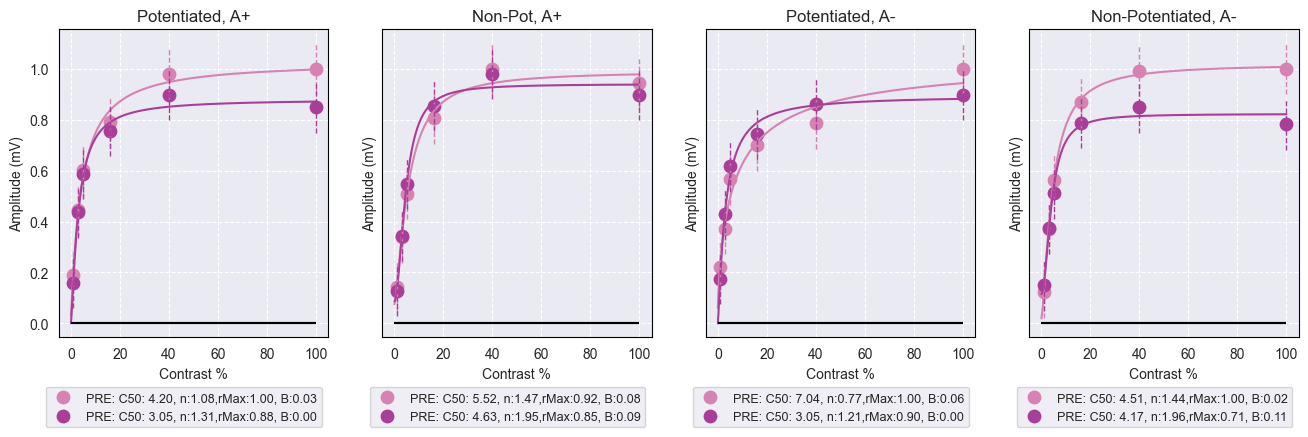

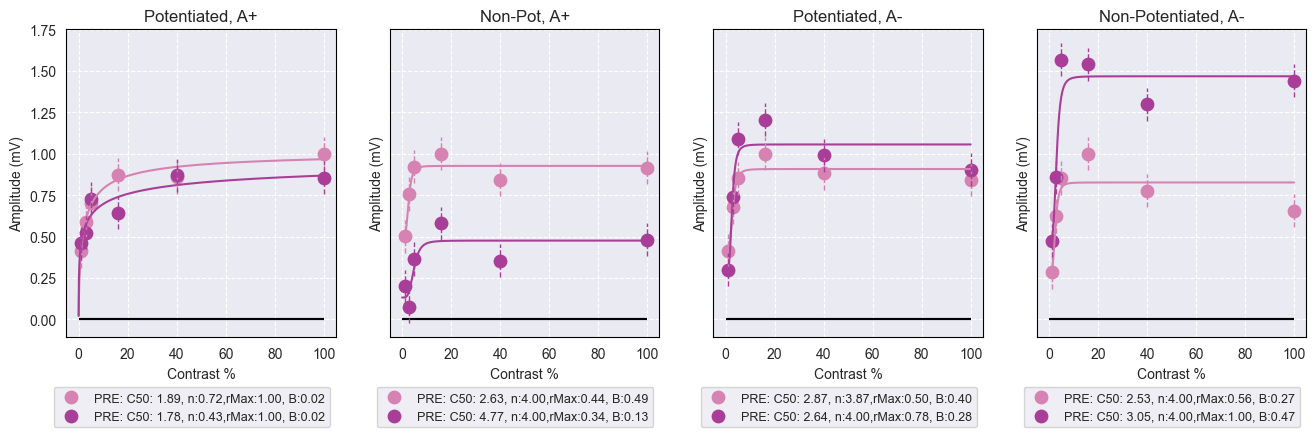

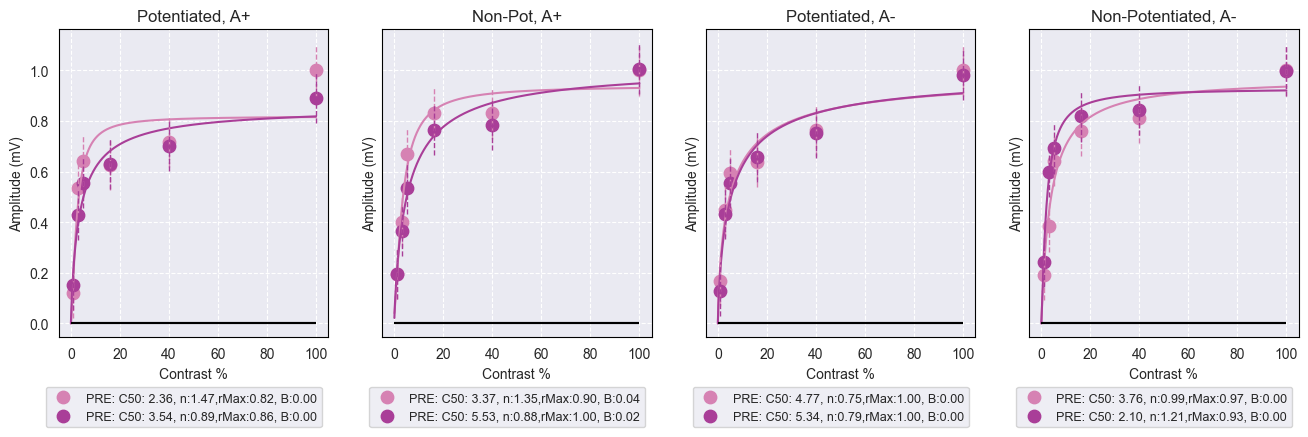

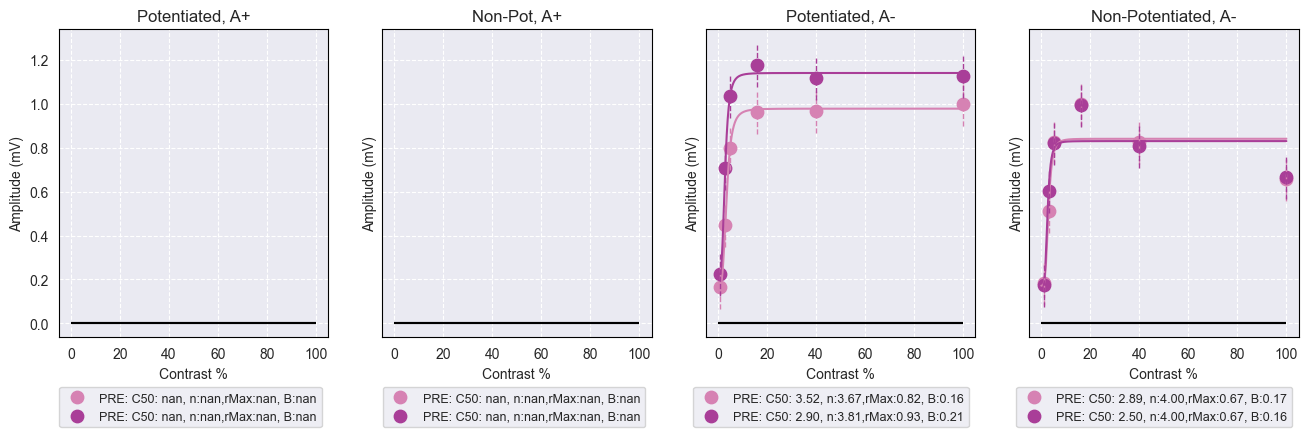

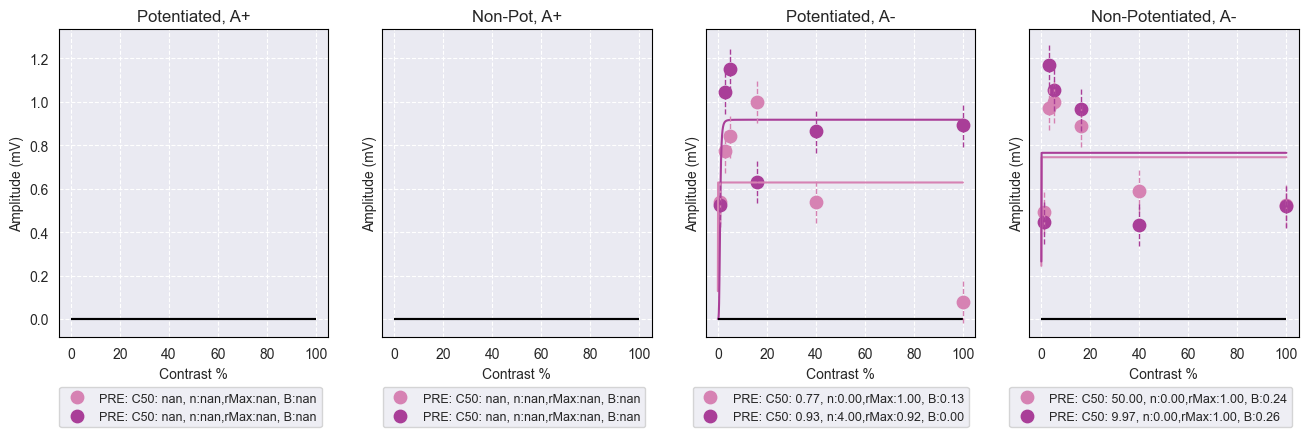

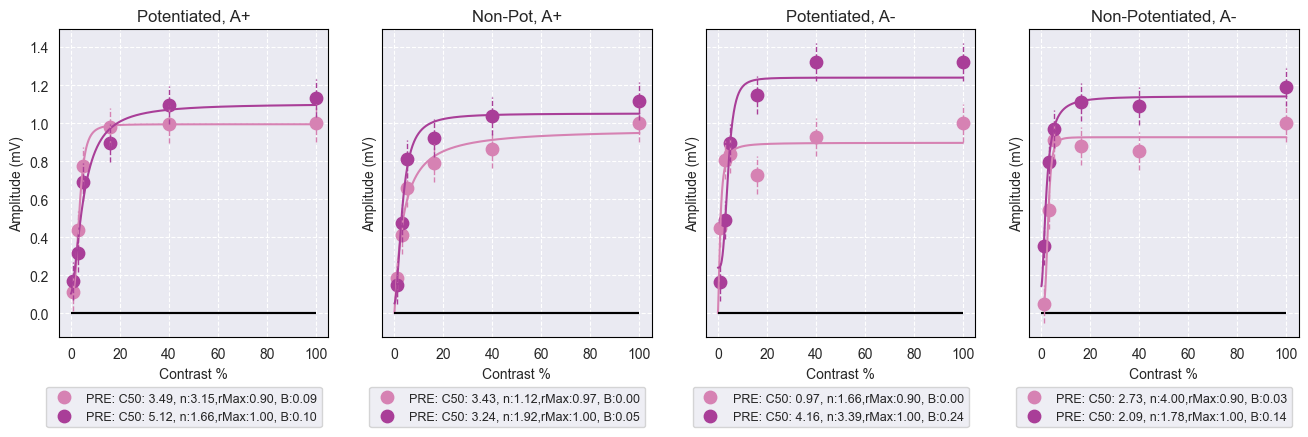

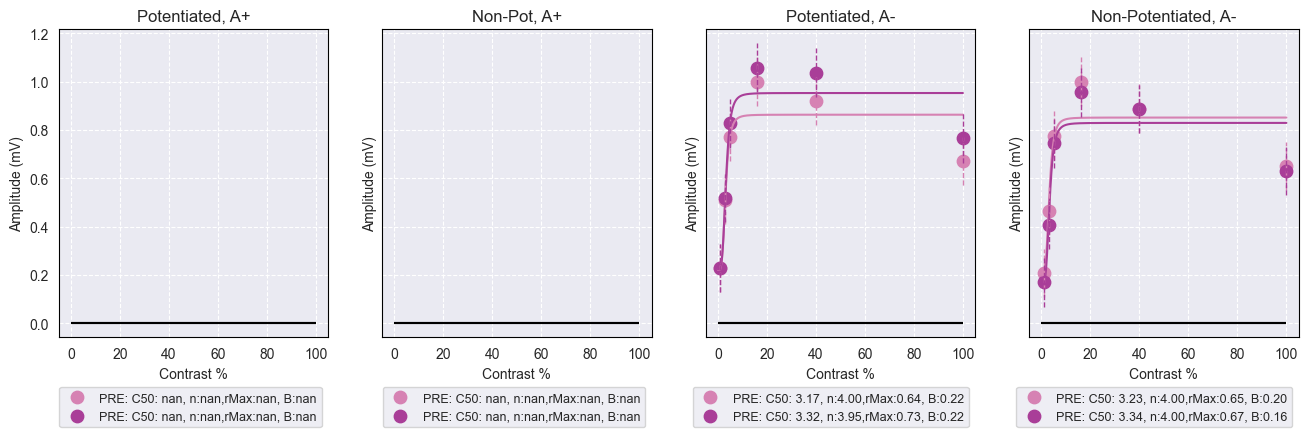

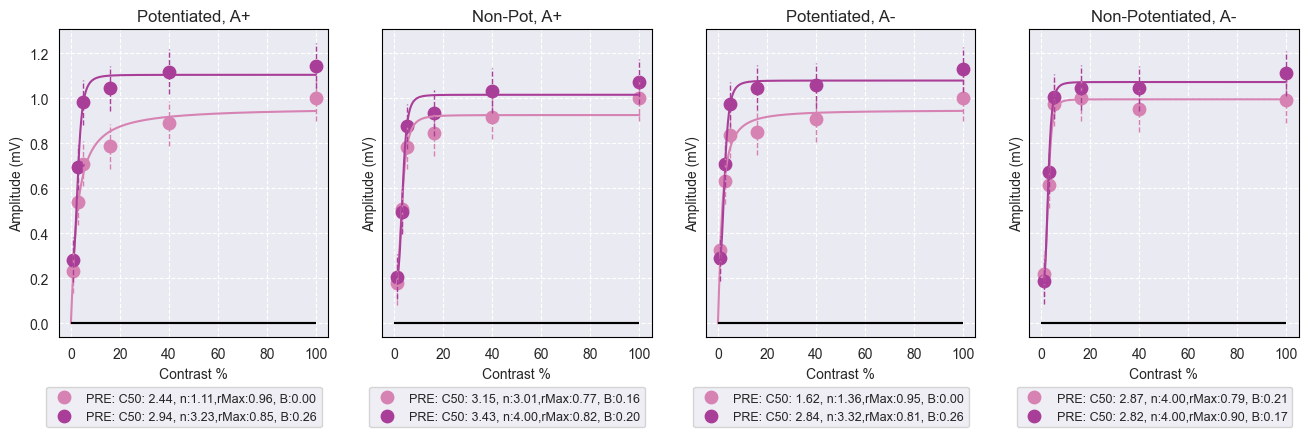

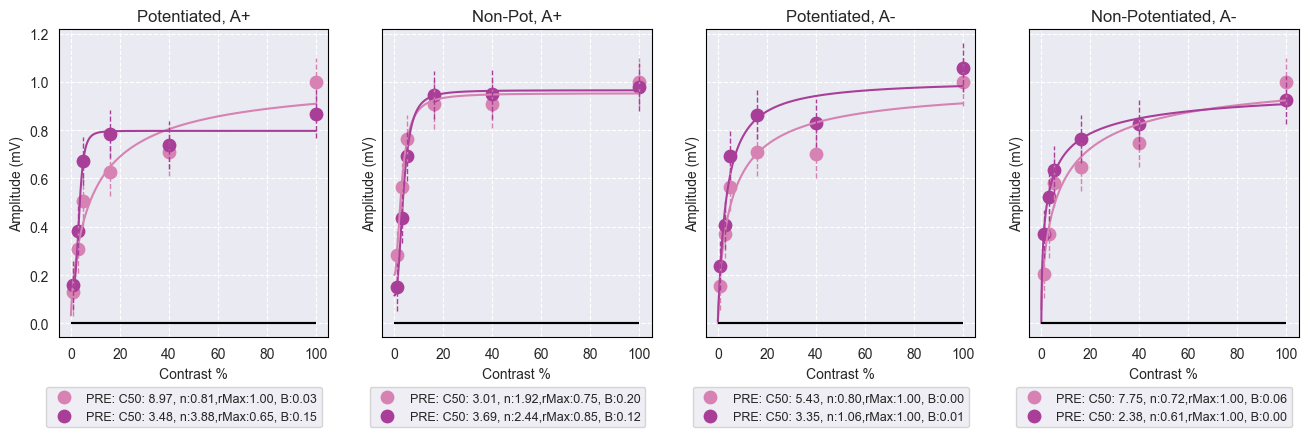

In [76]:
for subject in range(AllCondition_SmoothFits[0].shape[0]):
    fig,axs = plt.subplots(1,4,figsize = ((16,4)),sharey = True)
    for vx in range(4):
        smoothfitsimports = np.array(AllCondition_SmoothFits[vx][subject,:,:])
        crfimports = np.array(nr_Group[vx][subject,:,:])
        nr_fit_values = np.array(AllCondition_FitParams[vx][subject,:,:])
        for prepost in range(2):
            axs[vx].plot(x2,smoothfitsimports[prepost,:],color = fill[9+prepost])
            axs[vx].scatter(contrast_levels, crfimports[prepost,:],color = fill[9+prepost],marker = 'o', linewidths = 1, s = 80,label = f'PRE: C50: {nr_fit_values[prepost,0]:.2f}, n:{nr_fit_values[prepost,1]:.2f},rMax:{nr_fit_values[prepost,2]:.2f}, B:{nr_fit_values[prepost,3]:.2f}')
            axs[vx].set_title(f'{Condition_Label[vx]}')
            axs[vx].set_ylabel(f'Amplitude (mV)')
            axs[vx].set_xlabel(f'Contrast %')
            axs[vx].hlines(0,xmin = 0,xmax = 100, color = 'black')

        for x, y in zip(contrast_levels, crfimports[0,:]):
            axs[vx].vlines(x, ymin=y-0.10, ymax=y+0.10, color=fill[9], linestyle='--', linewidth=1)

        for x, y in zip(contrast_levels, crfimports[1,:]):
            axs[vx].vlines(x, ymin=y-0.10, ymax=y+0.10, color=fill[10],linestyle='--', linewidth=1)

            #legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
            axs[vx].legend(loc = 'upper right',fontsize = 9,bbox_to_anchor=(1, -0.14))

### code under contruction below

In [36]:
# ##################################################################
# def Init_NakaRushton_Fits(naka_rushton,DataSetIn, sIn):
#     DX = DataSetIn[sIn]
#     NR_Params_Generated = []
#     for coX in range(4): # 4 
#         dImport = DX[coX] # [2 x 2 x 6] # data IN
#         Hyperbolic_Parameters = np.zeros((int(dImport.shape[0]),2,4)) # [2 x 2 x 4] Data OUT
#         for harmonicIndicies in range(2):
#             Harmonic_CRF = dImport[harmonicIndicies]
#             for pre_post in range(2):
#                 crfIn = np.array(Harmonic_CRF[pre_post])
#                 # if data is missing, feed array of zeros
#                 if np.isnan(crfIn).all():
#                     crfIn = np.zeros_like((crfIn))
#                 Hyperbolic_Parameters[harmonicIndicies,pre_post,:], _ = curve_fit(naka_rushton,contrast_levels,crfIn,bounds=boundaries, nan_policy='omit', method='trf')
#         NR_Params_Generated.append(Hyperbolic_Parameters)
#     return NR_Params_Generated
# ###############################################################
# def Init_Smooth_Fits(naka_rushton,ContrastArr,Param_ValsMat,sIn):
#     paramsVals_2_smooth = Param_ValsMat[sIn] # import data [4 sets per subj, harmonic slicing already perf.]
#     Smooth_HyperRatios_Out = [] # list out 
#     for coX_params in range(4): # import data set 1 @ a time
#         nr_CoX_Values = paramsVals_2_smooth[coX_params]
#         # init empty list to store Smooth Fits
#         Smooth_HyperRatios = np.zeros((int(nr_CoX_Values.shape[0]),2,int(Full_Contrasts.shape[0])))
#         # import 1 harmonic data 
#         for hIndex in range((nr_CoX_Values.shape[0])):
#             hData = nr_CoX_Values[hIndex]
#             # import pre post 1 @ a time
#             for prepost_Index in range(2):
#                 CoX_paramVals = hData[prepost_Index]
#                 # perfom fit
#                 Smooth_HyperRatios[hIndex,prepost_Index,:] = naka_rushton(ContrastArr,CoX_paramVals[0],CoX_paramVals[1],CoX_paramVals[2],CoX_paramVals[3])
#         Smooth_HyperRatios_Out.append(Smooth_HyperRatios)
#     return Smooth_HyperRatios_Out # returns a list with 4 sublists each : {[HamIndicies, prepost, contrast simulations]]}

#### **Quantifying Supersaturation based on Owl Wulst paper and Ledgeway et al. (2005)**

In [37]:
# dataIn = PrePostConditionData[0] # [subject x prepost x contrast]

# PrePost_SaturationValues = np.zeros((int(dataIn.shape[0]),2)) #[subjx xsaturation index values]  # saturation index evaluation
# PrePost_SaturationValues_LocInstance = np.zeros((int(dataIn.shape[0]),2)) #[subj x saturation index values] # where saturation occured

# for CRF_SaturationEval in range(dataIn.shape[0]): # iterate through all subjects
#     for prepost in range(2): # iterate through pre post crfs
        
#         crf_data = dataIn[CRF_SaturationEval,prepost] # import 1 crf per iter

#         MaxResponseLoc = np.argmax(crf_data) # find where maximum response is
#         MaxResponseVal = crf_data[MaxResponseLoc] # find what ax response was given the locaiton

#         Response_at_100 = crf_data[5] # response at 100% contrast

#         pseudo_C50 = crf_data[3] # reponse at 60% contrast, not 40% or 50% (we dont have 50% :())

#         SI_response_change = (Response_at_100 - pseudo_C50)/ MaxResponseVal # Saturation Index Computation (Ledgeway et al. 2005) 

#         PrePost_SaturationValues[CRF_SaturationEval,prepost] = SI_response_change #store satruation index 
#         PrePost_SaturationValues_LocInstance[CRF_SaturationEval,prepost] = MaxResponseLoc # store contrast with saturation index

In [38]:
sat_crf = np.array(data[0])

for sub in range(sat_crf.shape[0]):
    for prepost in range(2):
        crfIn = sat_crf[sub,prepost,:]
        plt.plot(crfIn,color = fill[4])

NameError: name 'data' is not defined

In [ ]:
### Model Estimates...based on nothing soild - subject to change 
c50_b = [0,100] # contrast level that yeilds 50% of max response
n_b = [-1,2] # determin curve arc for fitting 
Rmax_b = [1,1.5] # max response 
b_b = [0,0.3] # starting value
s_b = [0,10]
boundaries=([c50_b[0],n_b[0],Rmax_b[0],b_b[0],s_b[0]], [c50_b[1],n_b[1],Rmax_b[1],b_b[1],s_b[1]])

print(boundaries)

In [ ]:
emptyMat = np.zeros((1,5))
emptyMat[:] = np.nan

Fit_Sat_Params = np.zeros((sat_crf.shape[0],2,5)) # [23,2,5]
for sub in range(sat_crf.shape[0]):
    for prepost in range(2):
        crfIn = sat_crf[sub,prepost,:]

        if np.isnan(crfIn).all():
            print('skipping this computation..., data not avilable')
            Fit_Sat_Params[sub,prepost,:] = emptyMat
        else:
            Fit_Sat_Params[sub,prepost,:], _ = curve_fit(naka_rushton_saturation,contrast_levels,crfIn,bounds = boundaries,nan_policy='omit', method='trf')

In [ ]:
ContrastArr = Full_Contrasts

SmoothSatFitsOut = np.zeros((sat_crf.shape[0],2,int(len(ContrastArr))))
print(SmoothFitsOut.shape) # [subj x prepost x crf nr fit estimations]

for subjFitVals in range(sat_crf.shape[0]):
    for prepost in range(2):
        SmoothSatFits = np.array(Fit_Sat_Params[subjFitVals,prepost,:]) # 4 values 
        SmoothSatFitsOut[subjFitVals,prepost,:] = naka_rushton_saturation(ContrastArr,SmoothSatFits[0],SmoothSatFits[1],SmoothSatFits[2],SmoothSatFits[3],SmoothSatFits[4])

In [ ]:
fig,axs = plt.subplots(figsize = (5,5))
sx = 4
crf__loc_vals = np.array(contrast_levels) - 1


axs.plot(x2,SmoothSatFitsOut[sx,0,:],linewidth = 1.5, color = fill[0], label = f'PRE: C50: {Fit_Sat_Params[sx,0,0]:.2f}, n:{Fit_Sat_Params[sx,0,1]:.2f},rMax:{Fit_Sat_Params[sx,0,2]:.2f}, B:{Fit_Sat_Params[sx,0,3]:.2f},S:{Fit_Sat_Params[sx,0,4]:.2f}')
axs.plot(x2,SmoothSatFitsOut[sx,1,:],linewidth = 1.5, color = fill[10], label = f'POST: C50: {Fit_Sat_Params[sx,1,0]:.2f}, n:{Fit_Sat_Params[sx,1,1]:.2f},rMax:{Fit_Sat_Params[sx,1,2]:.2f}, B:{Fit_Sat_Params[sx,1,3]:.2f},S:{Fit_Sat_Params[sx,1,4]:.2f}')

axs.scatter(contrast_levels, sat_crf[sx,0,:],color = fill[0],marker = 'o', linewidths = 1, s = 80)
axs.scatter(contrast_levels,sat_crf[sx,1,:],color = fill[10],marker = 'o', linewidths = 1, s = 80)

for x, y in zip(contrast_levels, sat_crf[sx,0,:]):
    plt.vlines(x, ymin=y-0.10, ymax=y+0.10, color=fill[0], linestyle='--', linewidth=1)

for x, y in zip(contrast_levels, sat_crf[sx,1,:]):
    plt.vlines(x, ymin=y-0.10, ymax=y+0.10, color=fill[10], linestyle='--', linewidth=1)



axs.legend()